In [132]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from thop import profile

In [133]:
# !pip install einops

In [134]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# Preparing Data

In [135]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 100
# proportion of validation set to training set
valid_size = 0.2
# set training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# convert data to torch.FloatTensor
train_tfms = transforms.ToTensor()
valid_tfms = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=train_tfms)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=valid_tfms)

# split the training dataset into training set and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

cuda


# FashionMNIST Dataset

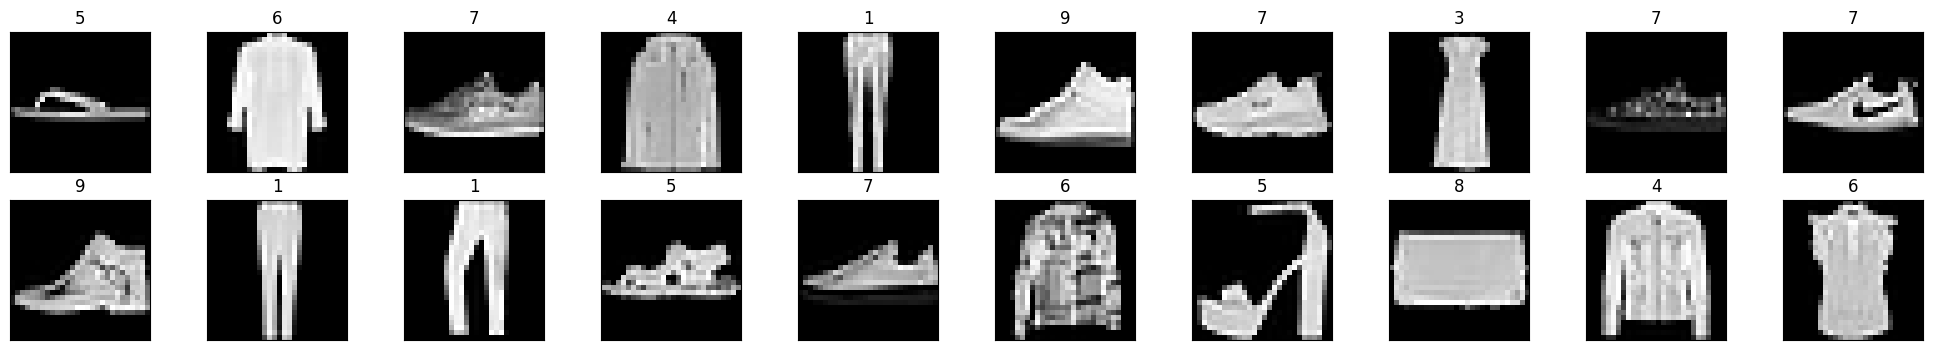

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Model Architecture

In [137]:
# def to_patch(img):
#       B, C, H, W = img.shape
#       x = torch.zeros((B, 49, 16))  # Number of patch : 49  size of patch : 16
#       for i in range(7):
#         for j in range(7):
#           x[:,i*7+j,:] = img[:,:,4*i:4*(i+1),4*j:4*(j+1)].reshape((B,16))

#       return x.to(device)

def to_patch(img, patch_size=4):
    B, C, H, W = img.shape
    x = torch.zeros((B, (H // patch_size) * (W // patch_size), patch_size * patch_size * C), device=img.device)
    
    patch_index = 0
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            x[:, patch_index, :] = img[:, :, i:i+patch_size, j:j+patch_size].reshape(B, -1)
            patch_index += 1

    return x

class Norm(nn.Module):
  """
  Layer normalization before multi-head attention block and mlp block in transformer encoder
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, dim):
    super().__init__()
    self.norm = nn.LayerNorm(dim)

  def forward(self, x):
    return self.norm(x)

class MLP(nn.Module):
  """
  Mutilayer perceptron (MLP) or Feed-forward network (FFN) block in transformer encoder
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, input_dim, hidden_dim, dropout=0):
    super().__init__()

    # Linear layers
    self.mlp1 = nn.Linear(input_dim, hidden_dim)
    self.mlp2 = nn.Linear(hidden_dim, input_dim)

    # Activation function
    self.act = nn.GELU()

    # Dropout layer
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.mlp1(x)
    x = self.act(x)
    x = self.mlp2(x)
    x = self.dropout(x)
    return x

class Multi_Head_Attention(nn.Module):
  """
  Muti-head attention block in transformer encoder
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  Muti-head attention architecure by: Attention Is All You Need
  https://arxiv.org/abs/1706.03762
  """
  def __init__(self, embed_dim, num_heads):
    super().__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads

    # Linear layers to project input to Q, K, V
    self.q_linear = nn.Linear(embed_dim, embed_dim)
    self.k_linear = nn.Linear(embed_dim, embed_dim)
    self.v_linear = nn.Linear(embed_dim, embed_dim)
    
    # Output linear layer
    self.out_linear = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    """
    Parameters of shape comments:
    B  batch size
    H  image height = 28
    W  image width  = 28
    PH patch height = 4
    PW patch width  = 4
    D  dimension
    HD number of heads = 4
    DH dimension each head
    """
    B, N, D = x.shape
    # Generate query, key and value (multiply by matrix Wq, Wk, Wv) by passing through an nn.Linear layer (learning)
    # and split into Q, K, V 3 chunks
                                                         # (B, (H/PH)*(W/PW)+1, D) -> (B, (H/PH)*(W/PW)+1, D) * 3
    Q = self.q_linear(x)
    K = self.k_linear(x)
    V = self.v_linear(x)

    # Split Q, K, V into num_head heads (e.g. num_head=4, dim=64)
    # (0-15 1st head, 16-31 2nd head, 32-47 3rd head, 48-63 4th head)
                                                         # (B, (H/PH)*(W/PW)+1, D) -> (B, HD, (H/PH)*(W/PW)+1, DH)
    Q = Q.view(B, self.num_heads, N, self.head_dim).transpose(1, 2)
    K = K.view(B, self.num_heads, N, self.head_dim).transpose(1, 2)
    V = V.view(B, self.num_heads, N, self.head_dim).transpose(1, 2)

    # Calculate attention score alpha = Q * K^T / sqrt(dk)
                                                         # (B, HD, (H/PH)*(W/PW)+1, (H/PH)*(W/PW)+1)
    alpha = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32, device=x.device))

    # Calculate attention matrix attention = softmax(alpha)
                                                         # (B, HD, (H/PH)*(W/PW)+1, (H/PH)*(W/PW)+1)
    atten_weight = torch.softmax(alpha, dim=-1)

    # Calculate output out = attention * V
                                                         # (B, HD, (H/PH)*(W/PW)+1, DH)
    out = torch.matmul(atten_weight, V)

    # Concatenate all the heads
                                                         # (B, HD, (H/PH)*(W/PW)+1, DH) -> (B, (H/PH)*(W/PW)+1, D)
    out = out.transpose(1, 2).contiguous().view(B, N, D)

    # Multiply by matrix Wo by passing through an nn.Linear layer (learning)
                                                         # (B, (H/PH)*(W/PW)+1, D)
    result = self.out_linear(out)

    return result

class Transformer_Encoder(nn.Module):
  """
  Transformer encoder in ViT model
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0):
    super().__init__()
    self.norm = Norm(embed_dim)
    self.mha = Multi_Head_Attention(embed_dim, num_heads)
    self.mlp = MLP(embed_dim, hidden_dim, dropout)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    y = self.norm(x)
    y = self.mha(y)
    x = x + y

    y = self.norm(x)
    y = self.mlp(y)
    x = x + y
    return x

class ViT(nn.Module):
  """
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, img_size=28, patch_size=4, in_channel=1, num_classes=10, embed_dim=64, num_heads=4, mlp_ratio=4, num_layers=4, dropout=0):
    super().__init__()

    self.image_to_patch = to_patch

    self.num_patches = (img_size // patch_size) ** 2  # 49
    self.embed_dim = embed_dim  # 4*4
    self.num_layers = num_layers

    # Class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    # Positional embedding
    self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim)* 0.02)

    self.patch_embed = nn.Linear(patch_size * patch_size * in_channel, embed_dim)
    self.encoder_layer = nn.ModuleList([
      Transformer_Encoder(embed_dim, num_heads, embed_dim * mlp_ratio, dropout)
      for _ in range(num_layers)
    ])
    self.cls_head = nn.Sequential(
      nn.LayerNorm(embed_dim),
      nn.Linear(embed_dim, num_classes)
    )

  def forward(self, x):
    # Transform image into patches
    x = self.image_to_patch(x)                            # (B, C, H, W) -> (B, (H/PH)*(W/PW), PH*PW*C)

    # Patch embedding
                                              # (B, (H/PH)*(W/PW), PH*PW*C) -> (B, (H/PH)*(W/PW), D)
    x = self.patch_embed(x)

    # Class tokens (learnable parameter)
                                              # (B, 1, D)
    B = x.size(0)
    class_token = self.class_token.expand(B, -1, self.embed_dim)

    # Conatenate class tokens to embedded patches
                                              # (B, (H/PH)*(W/PW), D) -> (B, (H/PH)*(W/PW)+1, D)
    x = torch.cat((class_token, x), dim=1)

    # Position embedding
                                              # (B, (H/PH)*(W/PW)+1, D) shape unchanged, element-wise addition
    x = x + self.pos_embed

    # Transfomer encoders with depth layers
                                              # (B, (H/PH)*(W/PW)+1, D) shape unchanged
    for encoder in self.encoder_layer:
      x = encoder(x)

    # Take the class token for classification
                                              # (B, (H/PH)*(W/PW)+1, D) -> (B, D)
    cls_token = x[:, 0]

    # MLP Head block for classification
                                              # (B, D) -> (B, CLS)
    x = self.cls_head(cls_token)
    return x

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ViT().to(device)

print(model)

cuda
ViT(
  (patch_embed): Linear(in_features=16, out_features=64, bias=True)
  (encoder_layer): ModuleList(
    (0-3): 4 x Transformer_Encoder(
      (norm): Norm(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (mha): Multi_Head_Attention(
        (q_linear): Linear(in_features=64, out_features=64, bias=True)
        (k_linear): Linear(in_features=64, out_features=64, bias=True)
        (v_linear): Linear(in_features=64, out_features=64, bias=True)
        (out_linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (mlp): MLP(
        (mlp1): Linear(in_features=64, out_features=256, bias=True)
        (mlp2): Linear(in_features=256, out_features=64, bias=True)
        (act): GELU(approximate='none')
        (dropout): Dropout(p=0, inplace=False)
      )
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (cls_head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_f

# Hyperparameters

In [139]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# number of epochs to train the model
n_epochs = 10

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# specify leaning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=len(train_loader)*n_epochs, 
    eta_min=1e-4, 
    last_epoch=-1
)


# Training and Validation

In [140]:
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
# initialize history for recording what we want to know
history = []

for epoch in range(n_epochs):
    # monitor training loss, validation loss and learning rate
    train_loss = 0.0
    valid_loss = 0.0
    lrs    = []
    result = {'train_loss': [], 'val_loss': [], 'lrs': []}

    # prepare model for training
    model.train()

    #######################
    # train the model #
    #######################
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        # record learning rate
        lrs.append(optimizer.param_groups[0]['lr'])

        # update running training loss
        train_loss += loss.item()*data.size(0)

        scheduler.step()

    ######################
    # validate the model #
    ######################

    model.eval()
    for data,target in valid_loader:
        data, target = data.to(device), target.to(device)
        # compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,target)
        # update running validation loss
        valid_loss += loss.item()*data.size(0)
    
    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_sampler)
    result['train_loss'] = train_loss
    valid_loss = valid_loss/len(valid_sampler)
    result['val_loss'] = valid_loss
    leaning_rate = lrs
    result['lrs'] = leaning_rate
    history.append(result)

    print('Epoch {:2d}: Learning Rate: {:.6f} Training Loss: {:.6f} Validation Loss:{:.6f}'.format(
        epoch+1,
        leaning_rate[-1],
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased({:.6f}-->{:.6f}). Saving model ..".format(
        valid_loss_min,
        valid_loss
        ))
        torch.save(model.state_dict(),"model.pt")
        valid_loss_min = valid_loss

Epoch  1: Learning Rate: 0.000978 Training Loss: 0.742346 Validation Loss:0.571938
Validation loss decreased(inf-->0.571938). Saving model ..
Epoch  2: Learning Rate: 0.000914 Training Loss: 0.520865 Validation Loss:0.508867
Validation loss decreased(0.571938-->0.508867). Saving model ..
Epoch  3: Learning Rate: 0.000815 Training Loss: 0.466707 Validation Loss:0.469052
Validation loss decreased(0.508867-->0.469052). Saving model ..
Epoch  4: Learning Rate: 0.000689 Training Loss: 0.430274 Validation Loss:0.441486
Validation loss decreased(0.469052-->0.441486). Saving model ..
Epoch  5: Learning Rate: 0.000550 Training Loss: 0.396742 Validation Loss:0.440176
Validation loss decreased(0.441486-->0.440176). Saving model ..
Epoch  6: Learning Rate: 0.000411 Training Loss: 0.361565 Validation Loss:0.408791
Validation loss decreased(0.440176-->0.408791). Saving model ..
Epoch  7: Learning Rate: 0.000286 Training Loss: 0.326141 Validation Loss:0.413148
Epoch  8: Learning Rate: 0.000186 Traini

# Plot Learning Rate Curve

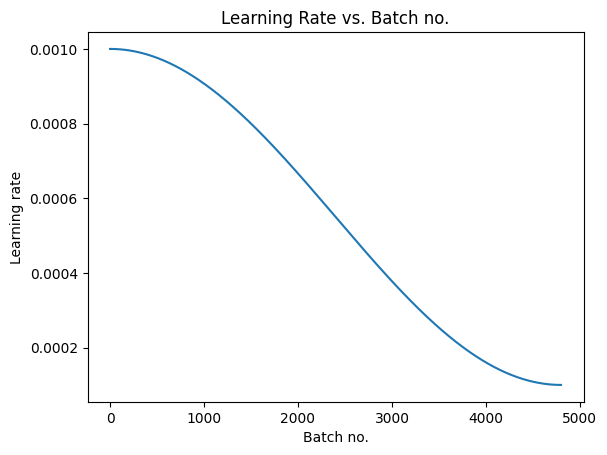

In [141]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

# Plot Loss Curve

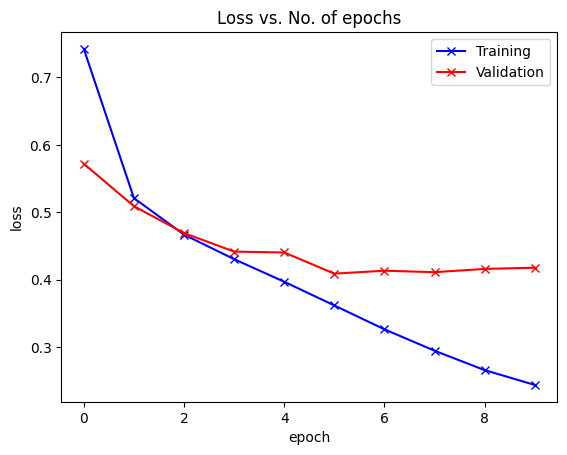

In [142]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Testing

In [143]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# prep model for evaluation
model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of Class %5s: %2.2f%% (%2d/%2d)' % (
            str(i),
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i])
            ))
    else:
        print('Test Accuracy of Class %5s: N/A (no training examples)' % (str[i]))

print('\nTest Accuracy (Overall): %2.2f%% (%2d/%2d)' % (
    100 * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total)
    ))

Test Loss: 0.437977

Test Accuracy of Class     0: 83.90% (839/1000)
Test Accuracy of Class     1: 96.30% (963/1000)
Test Accuracy of Class     2: 73.30% (733/1000)
Test Accuracy of Class     3: 85.60% (856/1000)
Test Accuracy of Class     4: 73.90% (739/1000)
Test Accuracy of Class     5: 93.20% (932/1000)
Test Accuracy of Class     6: 61.40% (614/1000)
Test Accuracy of Class     7: 94.70% (947/1000)
Test Accuracy of Class     8: 95.50% (955/1000)
Test Accuracy of Class     9: 93.90% (939/1000)

Test Accuracy (Overall): 85.17% (8517/10000)


# Testing Model Computational Cost

In [144]:
# pseudo image
image = torch.rand(1, 1, 28, 28).cuda()

out = model(image)

# torchsummary report
summary(model, input_size=(1, 28, 28))
print(f'From input shape: {image.shape} to output shape: {out.shape}')

# thop report
macs, parm = profile(model, inputs=(image, ))
print(f'MACs: {macs}, Params: {parm}.')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 49, 64]           1,088
         LayerNorm-2               [-1, 50, 64]             128
              Norm-3               [-1, 50, 64]               0
            Linear-4               [-1, 50, 64]           4,160
            Linear-5               [-1, 50, 64]           4,160
            Linear-6               [-1, 50, 64]           4,160
            Linear-7               [-1, 50, 64]           4,160
Multi_Head_Attention-8               [-1, 50, 64]               0
         LayerNorm-9               [-1, 50, 64]             128
             Norm-10               [-1, 50, 64]               0
           Linear-11              [-1, 50, 256]          16,640
             GELU-12              [-1, 50, 256]               0
           Linear-13               [-1, 50, 64]          16,448
          Dropout-14               [-